In [1]:
import numpy as np
import sympy as sp # for calculating derivative
import matplotlib.pyplot as plt

#import seaborn as sns # it will set to SNS style
#sns.reset_orig() # set back to the Matplotlib style
#sns.set() # set to sns style
# set the font
#plt.rcParams["font.family"] = 'arial'
%matplotlib notebook

from lmfit import minimize, Model, Minimizer, Parameters, Parameter, report_fit

In [30]:
print 'Sm2Zr2O7', np.array([85, 130, 165, 210])/8.065 # PRB Raman Sm2Zr2O7
print 'Sm2Ti2O7', np.array([87, 132, 158, 270])/8.065 # PRB Raman Sm2Ti2O7
print 'Sm2Ti2O7',np.array([172,212.7])/8.065 # JPCM for Sm2Ti2O7
print np.array([23,35])*8.065 # Our Nd2Zr2O7

Sm2Zr2O7 [ 10.53936764  16.11903286  20.45877247  26.03843769]
Sm2Ti2O7 [ 10.78735276  16.36701798  19.59082455  33.47799132]
Sm2Ti2O7 [ 21.3267204   26.37321761]
[ 185.495  282.275]


# # Calculate the CEF heat capacity

In [3]:
##### difine function for calculate and plot crystal field heat capacity
kb = 1.38*10**-23; 
nmol = 6*10**23; 
R = 8.31;
t = sp.symbols('t')

def cefcp(t, elevels, degen):  
    # this fun retures a sympy object containing symbol 't'
    e = elevels*11.606*kb; g = degen
    energy = nmol*sum([ei*gi*sp.exp(-ei/kb/t) for ei,gi in zip(e, g)])/sum([gi*sp.exp(-ei/kb/t) for ei,gi in zip(e, g)])
    cp = sp.diff(energy,t)# sp.Sum can not sum over a python list, but sum can and sp.diff works on the summation
    return cp

def lamcefcp(elevels, degen):
    # return a fun that take the temperature as varable which can be array
    cefcpv = sp.lambdify(t, cefcp(t, elevels, degen), modules=['numpy', 'sympy'])
    return cefcpv

def plotcefcp(tRange, npts, elevels, degen):     
    temps = np.linspace(tRange[0],tRange[1],num=npts,endpoint=True)
    cefcpv = lamcefcp(elevels, degen)  
    cefcpdat = cefcpv(temps)
    #fig, ax = plt.subplots()
    plt.plot(temps, cefcpdat)
    plt.minorticks_on()
    plt.xlabel(r"T (K)",size=14)
    plt.ylabel(r'$C_p$ (J/mol/K)',size=14)
    fig.show()
    return


In [4]:
e1 = np.array([0, 23, 34, 36, 106]); #e are in meV, now in J
g1 = np.array([2, 2, 2, 2, 2]); #Degenercy  
lamcefcp(e1, g1)(300)

3.7917511970696358

In [5]:
# Ｆｉｔ　ｔｈｅ　ｒｅｐｏｒｔｅｄ　Ｓｍ２Ｚｒ２Ｏ７　ＣＥＦ　Ｃｐ　ｄａｔａ
# load data
fnames = [r'D:\9_Program files\crystal_field\szo_cp.txt',
          r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\szo_cp_diditalized.txt',
          r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\sto_cp_diditalized.txt']
dat = np.genfromtxt(fnames[0]) # Spectre calculated
data = np.genfromtxt(fnames[1]) # data
data0 = np.genfromtxt(fnames[2]) # data

<IPython.core.display.Javascript object>


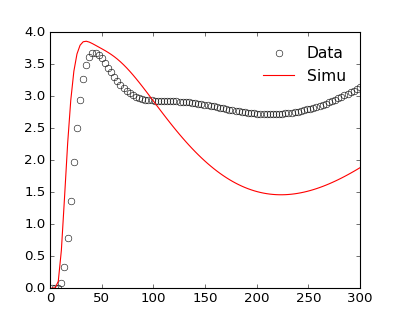

In [21]:
# Defined the fitting function
kb = 1.38*10**-23; 
nmol = 6*10**23; 
R = 8.31;
t = sp.symbols('t')
# The the fitted parameters can not be list but many varible
def szocefcp(x,e1,e2):# e1 and e2 in meV
    # this fun retures a sympy object containing symbol 't'
    e = np.array([0,e1,e2,130,157,168,183])*11.606*kb # includeing the first multiplet energy for Sm2Zr2O6
    g = [2.,2.,2.,2,2,2,2]
    energy = nmol*sum([ei*gi*sp.exp(-ei/kb/t) for ei,gi in zip(e, g)])/sum([gi*sp.exp(-ei/kb/t) for ei,gi in zip(e, g)])
    #cp = sp.diff(energy,t)# sp.Sum can not sum over a python list, but sum can and sp.diff works on the summation
    cpv = sp.lambdify(t, sp.diff(energy,t), modules=['numpy', 'sympy'])
    return cpv(x)


def fitplot(dat,title,fitReg):
    mod=Model(szocefcp)
    params = mod.make_params()
    params['e1'].set(value=16, vary=True, min=0, max=40)
    params['e2'].set(value=26, vary=True, min=0, max=40)

    mask = (fitReg[0]< dat[:,0]) & (dat[:,0] <fitReg[1]) # change the fitting range
    result = mod.fit(dat[mask,1], x=dat[mask,0], params = params)
    print result.fit_report(modelpars=None, show_correl=False)
    #print 'fitted:','\n', result.params.valuesdict()

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(dat[:,0], dat[:,1],marker='o',mec='black',mew=1,mfc='none',linestyle='None', label='Data')
    ax.plot(dat[mask,0], result.best_fit, 'r-', label='Fitting') 
    #ax.plot(dat[:,0],cefcp0(dat[:,0],15,35), label='Simu')
    
    params.loads(result.params.dumps()) 
    ax.text(200, 0.5,'Fitted'+'\n'+str(np.round(params['e1'].value,decimals=1))+'\n'
            +str(np.round(params['e2'].value,decimals=1))+' meV',
        verticalalignment='bottom', horizontalalignment='left',
        #transform=ax.transAxes,
        color='black', fontsize=15)
    plt.xlabel('T (K)',size=14)
    plt.ylabel('$C_p$ (J/K/mol)',size=14)

    plt.minorticks_on()
    plt.xticks( color='k', size=14)
    plt.yticks( color='k', size=14)
    
    ax.legend(loc='best',numpoints=1,frameon=False,framealpha=1,fontsize=14)
    #plt.title(title)
    #fig.savefig(r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\szo_cp_diditalized.pdf', bbox_inches="tight",verbose=True) 
    plt.show()
    return

# plot data and simulation
fig, ax = plt.subplots(figsize=(5, 4))
#sns.set(color_codes=True)
#ax.scatter(dat[:,0], dat[:,1],facecolors='none', label='Data')
ax.plot(dat[:,0], dat[:,1], marker='o',mec='black',mew=0.5,mfc='none',linestyle='None',label='Data') # mfc=None not work
ax.plot(dat[:,0],szocefcp(dat[:,0],6,20),c='r', label='Simu')

ax.legend(loc='best',numpoints=1,frameon=False,framealpha=1,fontsize=14)
plt.show()

[[Model]]
    Model(szocefcp)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 43
    # variables        = 2
    chi-square         = 4.643
    reduced chi-square = 0.113
    Akaike info crit   = -91.709
    Bayesian info crit = -88.187
[[Variables]]
    e1:   11.2619719 +/- 0.247439 (2.20%) (init= 16)
    e2:   28.8603212 +/- 0.875964 (3.04%) (init= 26)



<IPython.core.display.Javascript object>


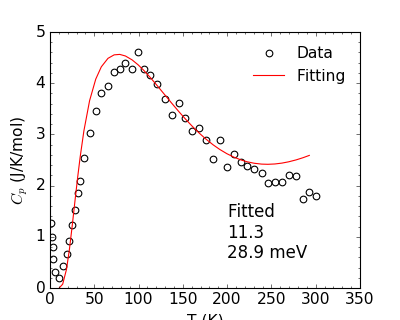

In [22]:
fitplot(data,r'Sm$_2$Zr$_2$O$_7$ Cp',[10,300])

[[Model]]
    Model(szocefcp)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 33
    # variables        = 2
    chi-square         = 72.011
    reduced chi-square = 2.323
    Akaike info crit   = 29.750
    Bayesian info crit = 32.743
[[Variables]]
    e1:   12.5610688 +/- 1.475858 (11.75%) (init= 16)
    e2:   21.7728990 +/- 3.321382 (15.25%) (init= 26)



<IPython.core.display.Javascript object>


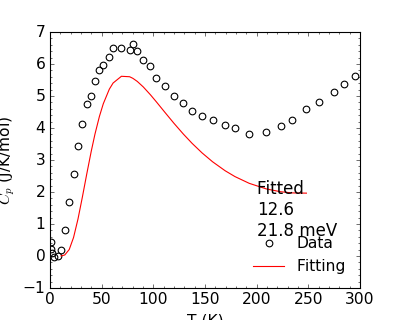

In [31]:
# Fit and plot SmTiO Cp
fitplot(data0,r'Sm$_2$Ti$_2$O$_7$ Cp',[10,250])# used the higher multiplet levels of SmZrO

<IPython.core.display.Javascript object>


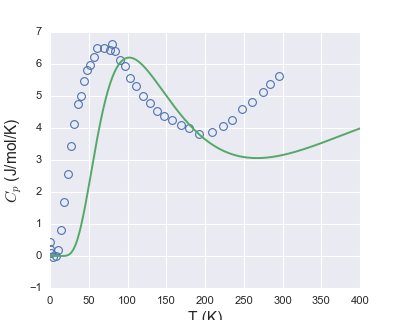

In [10]:
# cal the crystal field heat capacity
# Nd2Zr2O7
e1 = np.array([0, 23, 34, 36, 106]); #e are in meV, now in J
g1 = np.array([2, 2, 2, 2, 2]); #Degenercy  
# Sm2Ti2O7: take the JPCM pars
e1 = np.array([0, 21, 26, 136, 147,163,176]); #e are in meV, now in J
g1 = np.array([2, 2, 2, 2, 2, 2,2]); #Degenercy 
plt.figure(figsize=[5,4])
plt.plot(data0[:,0], data0[:,1],marker='o',mec='b',mew=1,mfc='none',linestyle='None', label='Data')
plotcefcp([1,400], 400, e1, g1)
#ax.set_ylim([0,10])

<IPython.core.display.Javascript object>


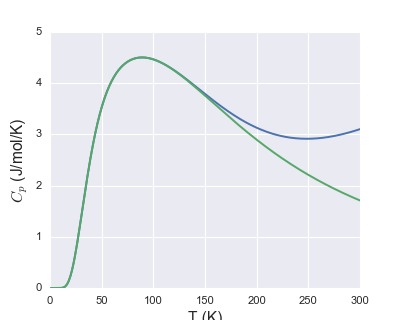

In [13]:
# cal the crystal field heat capacity of Sm2Zr2O7
plt.figure(figsize=[5,4])
e1 = np.array([0, 13, 34, 128, 157, 167, 183]); #e are in meV, now in J
g1 = np.array([2, 2, 2, 2, 2, 2, 2]); #Degenercy 

plotcefcp([1,300], 400, e1, g1)
e1 = np.array([0, 13, 34]); #e are in meV, now in J
g1 = np.array([2, 2, 2]); #Degenercy
plotcefcp([1,300], 400, e1, g1)
#ax.set_ylim([0,10])

# Calculated susceptibility of single crystal Pyrochlore from the SPECTRE data

In [32]:
# Ｒｏｔａｔｉｏｎ　ｍａｔｒｉｘ
#from http://stackoverflow.com/questions/6802577/python-rotation-of-3d-vector

# first method
import numpy as np
from scipy.linalg import expm3, norm
def M(axis, theta):
    return expm3(np.cross(np.eye(3), axis/norm(axis)*theta))
#axis, theta = [1,1,1], 2*np.pi/3
#print M(axis, theta)


# Scond method
import numpy as np
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    theta = np.asarray(theta)
    axis = axis/np.sqrt(np.dot(axis, axis))
    a = np.cos(theta/2.0)
    b, c, d = -axis*np.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    m =  np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                   [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                   [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])
    m[m<=0.0001] = 0 # zero out the samll values
    return m

print rotation_matrix([1,1,1],2*np.pi/3)

[[ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]]


In [189]:
import numpy as np
from numpy import linalg as LA
import string
from scipy import interpolate

def crysXT(fpath, Hdirections):
    '''     
    'fpath' is a string giveing the path of the T-Chiz-Chixy-ChiPowder file produceed by SPECTRE;
    'Hdirections' is a n by 3 array showing the field directions and it can be normalized to be 1 oe later.   
    '''
    
    ## load the chi-T data of Spectre: T,  chiz, (chix+chiy)/2, chi_powder
    rule = string.maketrans('D', 'E') # make a translation table (rules) for translating a string (D to E in the numbers)
    data = np.genfromtxt(fpath, usecols=(0,1,2),names='T, chiz, chixy', \
                         converters = {1: lambda val: float(val.translate(rule)),
                                       2: lambda val: float(val.translate(rule))})

    chixyz = np.vstack((data['chixy'],data['chixy'],data['chiz'])).T
    #chixyz = np.vstack((data[:,2],data[:,2],data[:,1])).transpose()
    
    ## prepare the matrix to store the crystal chi
    crystal = np.zeros((data.shape[0],Hdirections.shape[0]+1))
    crystal[:,0] = data['T']
    
    Hdirections = (Hdirections.T/np.linalg.norm(Hdirections, axis=1)).T # normalize the field to be unit
    
    # the matrixes transforming the mag field to the 4 local frames on a tetrahedra 
    #(from Owen's Paper'A general theory of anisotropic... ')
    r1 = np.array([[-2,1,1]/np.sqrt(6.),[0,-1,1]/np.sqrt(2.),[1,1,1]/np.sqrt(3.)])
    r2 = np.array([[-2,-1,-1]/np.sqrt(6.),[0,1,-1]/np.sqrt(2.),[1,-1,-1]/np.sqrt(3.)])
    r3 = np.array([[2,1,-1]/np.sqrt(6.),[0,-1,-1]/np.sqrt(2.),[-1,1,-1]/np.sqrt(3.)])
    r4 = np.array([[2,-1,1]/np.sqrt(6.),[0,1,1]/np.sqrt(2.),[-1,-1,1]/np.sqrt(3.)])
    
    for idx, H in enumerate(Hdirections):
        #print H, idx
        #chi_atom = [chix,chiy,chiz] dot [hx COSa, hy cosb, hz cosc] /mod(H) where cosa=hx/mod(H) and mod(H)=1
        # [hx COSa, hy cosb, hz cosc] for the for the four atoms
        h1, h2, h3, h4 = np.dot(r1,H)**2, np.dot(r2,H)**2,\
                         np.dot(r3,H)**2, np.dot(r4,H)**2
        #print h1, h2, h3, h4
        
        # sum up the magnetizations of the four atoms and the average
        crystal[:,idx+1] = (np.dot(chixyz,h1)+np.dot(chixyz,h2)+ \
                            np.dot(chixyz,h3)+np.dot(chixyz,h4))/4.
    return crystal

import matplotlib.pyplot as plt
% matplotlib inline

def plotXT(data):
    fig, ax = plt.subplots(figsize = (5,4))
    ax.plot(data[:,0],data[:,1]**-1,label = '100')
    ax.plot(data[:,0],data[:,2]**-1,label = '110')
    ax.plot(data[:,0],data[:,3]**-1,label = '111')
    ax.minorticks_on()
    
    plt.xlabel(r"T (K)",size=14)
    plt.ylabel(r'$\frac{1}{\chi}$ (emu/mol)',size=14)
    plt.legend(loc = 'best')
    fig.show()
    return fig,ax


def crysMH(fpath, Hdirections, Hrange, npts):
    '''     
    'fpath' is a string giveing the path of the H-Mx-My-Mz file produceed by SPECTRE;
    'Hdirections' is a n by 3 array showing the field directions and it can be normalized to be 1 oe later.
    ' Hrange' is [Hmin,Hmax], Hmax should be smaller than the max field in the fpath file.
    'npts' is number of points
    '''    
    ## load the data of Spectre
    rule = string.maketrans('D', 'E') # make a translation table (rules) for translating a string (D to E in the numbers)
    data = np.genfromtxt(fpath, usecols=(0,1,2,3),names='Hz, mzx, mzy, mzz', \
                         converters = {1: lambda val: float(val.translate(rule)),
                                       2: lambda val: float(val.translate(rule)),
                                       3: lambda val: float(val.translate(rule))})  
    # the function for calculating the magnetization: g-tensor, a funciton of field and temperature
    # here it is not incorrect, we should take a Hx mxx, Hy myy, and Hz, mzz
    px = interpolate.interp1d(data['Hz'],data['mzx'])
    py = interpolate.interp1d(data['Hz'],data['mzy'])
    pz = interpolate.interp1d(data['Hz'],data['mzz'])
    
    ## prepare the matrix to store the crystal chi
    hs = np.linspace(Hrange[0],Hrange[1],npts)
    crystal = np.zeros((hs.shape[0],Hdirections.shape[0]+1))
    crystal[:,0] = hs
        
    Hdirections = (Hdirections.T/np.linalg.norm(Hdirections, axis=1)).T # normalize the field to be 1 unit
    
    # the matrixes transforming the mag field to the 4 local frames on a tetrahedra 
    #(from Owen's Paper'A general theory of anisotropic... ')
    r1 = np.array([[-2,1,1]/np.sqrt(6.),[0,-1,1]/np.sqrt(2.),[1,1,1]/np.sqrt(3.)])
    r2 = np.array([[-2,-1,-1]/np.sqrt(6.),[0,1,-1]/np.sqrt(2.),[1,-1,-1]/np.sqrt(3.)])
    r3 = np.array([[2,1,-1]/np.sqrt(6.),[0,-1,-1]/np.sqrt(2.),[-1,1,-1]/np.sqrt(3.)])
    r4 = np.array([[2,-1,1]/np.sqrt(6.),[0,1,1]/np.sqrt(2.),[-1,-1,1]/np.sqrt(3.)])
    
    for idx0, h in enumerate(hs):
        for idx1, H in enumerate(Hdirections):
            # the unit vector of the field in different local frames
            u1, u2, u3, u4 = np.abs(np.dot(r1,H)), np.abs(np.dot(r2,H)),\
                             np.abs(np.dot(r3,H)), np.abs(np.dot(r4,H))
            
            uss = np.array([u1, u2, u3, u4]) # a 4 by 3 matrix
            #h1, h2, h3, h4 = np.array([h*u1, h*u2, h*u3, h*u4])
            hss = uss*h # the magnetic field in the local frames          
            mss = np.array([px(hss[:,0]), py(hss[:,1]), pz(hss[:,2])]).T # the moment vectors of the atoms in local frames   
            
            m = np.sum(np.multiply(mss, uss))/4 # project the moment to field direction and sum up, average 4 atoms
            crystal[idx0,idx1+1] = m
    return crystal

#　ｔｒｙ　ｕｓｅ　ｇ　ｆａｃｔｏｒ　ａｎｄ　ｔｈｅｒｍａｌ　ｖａｖｅｒａｇｅ：　ｆａｉｌｅｄ
def crysMHg(fpath, Hdirections, Hrange, npts):
    '''     
    'fpath' is a string giveing the path of the H-Mx-My-Mz file produceed by SPECTRE;
    'Hdirections' is a n by 3 array showing the field directions and it can be normalized to be 1 oe later.
    ' Hrange' is [Hmin,Hmax], Hmax should be smaller than the max field in the fpath file.
    'npts' is number of points
    '''    
    ## load the data of Spectre
    rule = string.maketrans('D', 'E') # make a translation table (rules) for translating a string (D to E in the numbers)
    data = np.genfromtxt(fpath, usecols=(0,1,2,3),names='Hz, mzx, mzy, mzz', \
                         converters = {1: lambda val: float(val.translate(rule)),
                                       2: lambda val: float(val.translate(rule)),
                                       3: lambda val: float(val.translate(rule))})  
    # the function for calculating the magnetization: g-tensor, a funciton of field and temperature
    # here it is not incorrect, we should take a Hx mxx, Hy myy, and Hz, mzz
    gfactor = np.array([[0.001,0,0],[0.0001,0,0],[0,0,5.2]])
    
    ## prepare the matrix to store the crystal chi
    hs = np.linspace(Hrange[0],Hrange[1],npts)
    crystal = np.zeros((hs.shape[0],Hdirections.shape[0]+1))
    crystal[:,0] = hs
        
    Hdirections = (Hdirections.T/np.linalg.norm(Hdirections, axis=1)).T # normalize the field to be 1 unit
    
    # the matrixes transforming the mag field to the 4 local frames on a tetrahedra 
    #(from Owen's Paper'A general theory of anisotropic... ')
    r1 = np.array([[-2,1,1]/np.sqrt(6.),[0,-1,1]/np.sqrt(2.),[1,1,1]/np.sqrt(3.)])
    r2 = np.array([[-2,-1,-1]/np.sqrt(6.),[0,1,-1]/np.sqrt(2.),[1,-1,-1]/np.sqrt(3.)])
    r3 = np.array([[2,1,-1]/np.sqrt(6.),[0,-1,-1]/np.sqrt(2.),[-1,1,-1]/np.sqrt(3.)])
    r4 = np.array([[2,-1,1]/np.sqrt(6.),[0,1,1]/np.sqrt(2.),[-1,-1,1]/np.sqrt(3.)])
    
    for idx0, h in enumerate(hs):
        for idx1, H in enumerate(Hdirections):
            for atom in np.arrang((0,3)):
                u0 = np.abs(np.dot(r1,H))
                H0 = u0*h

                fun = lambda the, phi: gfactor*np.array([np.sin(the)*np.cos(phi),\
                                                        np.sin(the)*np.sin(phi),\
                                                       np.cos(the)])*2
                np.dot(H0,np.dot(gfactor, ))
            # the unit vector of the field in different local frames
            u1, u2, u3, u4 = np.abs(np.dot(r1,H)), np.abs(np.dot(r2,H)),\
                             np.abs(np.dot(r3,H)), np.abs(np.dot(r4,H))
            
            uss = np.array([u1, u2, u3, u4]) # a 4 by 3 matrix
            #h1, h2, h3, h4 = np.array([h*u1, h*u2, h*u3, h*u4])
            hss = uss*h # the magnetic field in the local frames          
             # the moment vectors of the atoms in local frames   
            hss
            
            m = np.sum(np.multiply(mss, uss))/4 # project the moment to field direction and sum up, average 4 atoms
            crystal[idx0,idx1+1] = m
    return crystal


def plotMH(data):
    fig, ax = plt.subplots(figsize = (5,4))
    ax.plot(data[:,0],data[:,1],label = '100')
    ax.plot(data[:,0],data[:,2],label = '110')
    ax.plot(data[:,0],data[:,3],label = '111')
    ax.minorticks_on()
    
    plt.xlabel(r"H (T)",size=14)
    plt.ylabel(r'M ($\mu_B/at$)',size=14)
    plt.legend(loc = 'best')
    fig.show()
    return fig,ax

In [136]:
# two methods to divide along row
a = np.arange(1,61, dtype=float).reshape((3,4,5)) # Create a 3d array 
a.shape                                           # (3,4,5)

b = np.array([1.0, 2.0, 3.0, 4.0])                # Create a 1-d array
b.shape                                           # (4,)

#a / b                                             # Gives a ValueError

print a / b[:, np.newaxis]   
#print a
print (a.swapaxes(1,2)/ b).swapaxes(1,2)   

[[[  1.           2.           3.           4.           5.        ]
  [  3.           3.5          4.           4.5          5.        ]
  [  3.66666667   4.           4.33333333   4.66666667   5.        ]
  [  4.           4.25         4.5          4.75         5.        ]]

 [[ 21.          22.          23.          24.          25.        ]
  [ 13.          13.5         14.          14.5         15.        ]
  [ 10.33333333  10.66666667  11.          11.33333333  11.66666667]
  [  9.           9.25         9.5          9.75        10.        ]]

 [[ 41.          42.          43.          44.          45.        ]
  [ 23.          23.5         24.          24.5         25.        ]
  [ 17.          17.33333333  17.66666667  18.          18.33333333]
  [ 14.          14.25        14.5         14.75        15.        ]]]
[[[  1.           2.           3.           4.           5.        ]
  [  3.           3.5          4.           4.5          5.        ]
  [  3.66666667   4.        

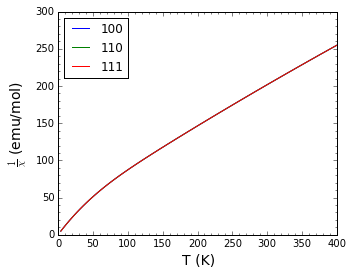

In [162]:
#Ｆｏｒ　Ｎｄ２Ｚｒ２Ｏ７
fpath = 'D:/9_Program files/crystal_field/Spectre/NdZr2O7/chi_180915_2.dat'
Hs = np.array([[1,0,0],[1,1,0],[1,1,1]])
crystalx = crysXT(fpath, Hs)
#print crystalx
plotXT(crystalx);


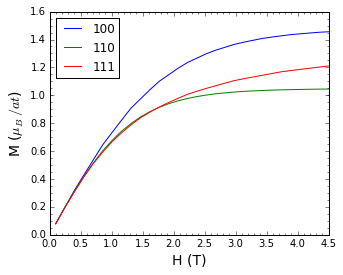

In [190]:
fpath = 'D:/9_Program files/crystal_field/Spectre/NdZr2O7/nd_mh.dat'
Hs = np.array([[1,0,0],[1,1,0],[1,1,1]])
crystal = crysMH(fpath, Hs, [0.1,4.5], 30)
#print crystalx
plotMH(crystal);